- Labeled abstracts using simple keyword matches (supervised / unsupervised / RL).
- Used only keyword-labeled abstracts for training (others marked as unknown).
- Trained SciBERT on these noisy labels.
- Predicted ML categories for all abstracts after training.


## Setup

In [3]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections

In [9]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [10]:
# Constants

CREATE_ABSTRACTS_DATASET = False

# Number of topics used for K-means
n_topics = 8

#### Create Abstracts dataset (only need to do this once)

In [11]:
# Helper: Clean Abstracts
# Basic text cleaning

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Remove Scopus copyright header 
    text = re.sub(r"^©\s*\d{0,4}\s*the author\(s\)\s*", "", text, flags=re.IGNORECASE)

    # Then apply the normal cleaning
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [12]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


In [13]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


Loaded 32714 abstracts


In [14]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,the detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",under exclusive license to springer nature swi...


## Create Topics with K-Means Clustering

In [15]:
# # TF-IDF vectorization

# # Convert cleaned abstracts to TF-IDF features
# tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
# X = tfidf.fit_transform(df["clean_abs"])

# print(f"TF-IDF shape: {X.shape}")


In [16]:
# # K-Means topic clustering

# km = KMeans(n_clusters=n_topics, random_state=42)
# df["topic"] = km.fit_predict(X)

# df["topic"].value_counts().sort_index()

In [17]:
# # Show top TF-IDF words per topic
# terms = tfidf.get_feature_names_out()

# for i in range(n_topics):
#     idx = km.cluster_centers_[i].argsort()[::-1][:10]
#     top_terms = [terms[j] for j in idx]
#     print(f"Topic {i}: {', '.join(top_terms)}")


In [18]:
# # Count how many abstracts per query belong to each topic
# topic_dist = df.groupby(["query_id", "topic"]).size().unstack(fill_value=0)

# plt.figure(figsize=(10,5))
# sns.heatmap(topic_dist, cmap="Blues", annot=True, fmt="d")
# plt.title("Topic distribution across queries")
# plt.ylabel("Query ID")
# plt.xlabel("Topic")
# plt.show()


In [19]:
# Save results for later analysis
# save_path = table_path / "abstract_topics.csv"
# df.to_csv(save_path, index=False)
# print(f"Saved topic assignments to: {save_path}")

## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [20]:
# Gather all keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement.txt"),
    }


ml_keywords = load_all_keywords()


In [21]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: any(contains_keyword(str(t).lower(), w) for w in ml_keywords[lab])

    )
    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,the detection of anomalies in production proce...,False,True,False
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",under exclusive license to springer nature swi...,False,True,False


In [22]:
# Create a column: "ml_type" that lists all categorys with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,the detection of anomalies in production proce...,False,True,False,[unsupervised]
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",under exclusive license to springer nature swi...,False,True,False,[unsupervised]
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",under exclusive license to springer nature swi...,True,True,False,"[supervised, unsupervised]"
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,the critical necessity for sophisticated predi...,True,True,False,"[supervised, unsupervised]"
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,the authorsthe border gateway protocol bgp is ...,False,True,False,[unsupervised]


In [23]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          19265
supervised        9949
unsupervised      3843
reinforcement     1851
Name: count, dtype: int64

In [24]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,27,275,75,590
ml_automation,114,314,1157,146
ml_defect_detection,20,288,329,120
ml_manufacturing_optimization,297,1077,2455,304
ml_planning_production,209,771,1260,193
ml_plm,8,70,169,14
ml_predictive_maintenance,168,1533,2359,724
ml_process_control,203,976,1905,355
ml_process_modeling,36,189,502,62


In [25]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.304121
is_unsupervised     0.117473
is_reinforcement    0.056581
dtype: float64

<Axes: xlabel='ml_type'>

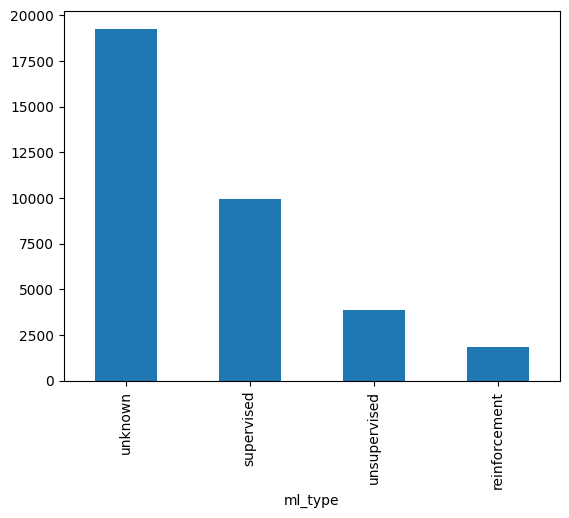

In [26]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [27]:
# Sample of abstracts that were classified as "unknown"
# Should analyze to improve keyword sets
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(10)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
2990,ml_defect_detection,2-s2.0-85071729472,10.1109/ICEAST.2019.8802526,Defect detection of particleboards by visual a...,© 2019 IEEE.Particleboards may exhibit several...,ieeeparticleboards may exhibit several defect ...,False,False,False,[unknown]
28993,ml_quality_control,2-s2.0-85146492458,10.1109/ICIRCA54612.2022.9985522,A Comparative Study on Application of Artifici...,© 2022 IEEE.Increasing demands in industrial p...,ieeeincreasing demands in industrial processes...,False,False,False,[unknown]
31037,ml_rul,2-s2.0-85178348288,NaN,A Grey-box Approach for the Prognostic and Hea...,© 2023 Prognostics and Health Management Socie...,prognostics and health management society all ...,False,False,False,[unknown]
13068,ml_predictive_maintenance,2-s2.0-85119683081,10.1109/FiCloud49777.2021.00031,AI based Diagnostic Service for IOT enabled Sm...,© 2021 IEEE.High end refrigerators come with a...,ieeehigh end refrigerators come with an ice di...,False,False,False,[unknown]
15221,ml_process_control,2-s2.0-85165653904,10.1002/cjce.25054,Control valve stiction detection using Markov ...,© 2023 The Authors. The Canadian Journal of Ch...,the authors the canadian journal of chemical e...,False,False,False,[unknown]
31159,ml_rul,2-s2.0-85139495576,10.1680/jbren.21.00093,A review of latest trends in bridge health mon...,© 2022 ICE Publishing: All rights reserved.Str...,ice publishing all rights reservedstructural d...,False,False,False,[unknown]
27592,ml_production_optimization,2-s2.0-85074188305,10.29227/IM-2019-01-47,IoT platforms for the Mining Industry: An over...,© 2019 Polish Mineral Engineering Society. All...,polish mineral engineering society all rights ...,False,False,False,[unknown]
18307,ml_process_optimization,2-s2.0-85174457825,10.1038/s41524-023-01152-y,A machine learning method to quantitatively pr...,"© 2023, Springer Nature Limited.Quantitatively...",springer nature limitedquantitatively defining...,False,False,False,[unknown]
7219,ml_planning_production,2-s2.0-86000479958,10.1080/21681015.2025.2471905,Enhancing production planning in metal-mechani...,© 2025 Chinese Institute of Industrial Enginee...,chinese institute of industrial engineersmetal...,False,False,False,[unknown]
32170,ml_supply_chain,2-s2.0-85209852606,10.1016/B978-0-443-28947-7.00009-4,Artificial intelligence and machine intelligen...,© 2025 Elsevier Inc. All rights reserved.Bioen...,elsevier inc all rights reservedbioenergy is w...,False,False,False,[unknown]


### Check most common ML method (most common keyword)



In [21]:
# all_text = " ".join(df["clean_abs"])

# method_counts = collections.Counter()

# for label, words in ml_keywords.items():
#     for w in words:
#         # Regex: match keyword as a whole word, case-insensitive
#         pattern = rf"\b{re.escape(w)}\b"
#         count = df["clean_abs"].str.contains(pattern, regex=True, case=False).sum()
#         method_counts[w] = count

# method_counts.most_common(20)

### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Training a Multi-Label ML-Method Classifier Using Keyword Pseudo-Labels

- The keyword-based approach provides noisy but useful initial labels for each article (e.g., supervised / unsupervised / reinforcement).  
- In the following steps, we use these pseudo-labels to train a **multi-label transformer model** (e.g., SciBERT or DistilBERT) on the abstracts. 
- This allows the model to learn richer linguistic patterns and produce more accurate classifications than the raw keyword method, while requiring **no manual labeling up front**.


In [47]:
import torch
print(torch.__version__)

2.9.1+cu128


In [28]:
from datasets import Dataset
import numpy as np

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Keep only rows that have at least one positive label (optional but often useful)
df_model = df.copy()
mask_any_label = df_model[label_cols].sum(axis=1) > 0
df_model = df_model[mask_any_label].reset_index(drop=True)

print(df_model[label_cols].mean())  # quick check of label frequencies

dataset = Dataset.from_pandas(df_model[["clean_abs"] + label_cols])

# Train/validation split
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]



/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


is_supervised       0.739758
is_unsupervised     0.285746
is_reinforcement    0.137631
dtype: float64


In [35]:
# Ensure scibert directory exists
scibert_path = processed_abstracts_path / "scibert"
scibert_path.mkdir(parents=True, exist_ok=True)

# Save datasets
train_path = scibert_path / "train_ds.csv"
val_path = scibert_path / "val_ds.csv"

train_ds.to_csv(train_path, index=False)
val_ds.to_csv(val_path, index=False)

print(f"Saved train_ds to: {train_path}")
print(f"Saved val_ds to:   {val_path}")

Creating CSV from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 28.64ba/s]

Saved train_ds to: ../../data/processed/abstracts/scibert/train_ds.csv
Saved val_ds to:   ../../data/processed/abstracts/scibert/val_ds.csv


In [36]:
train_ds.to_pandas().head()


,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,th european conference on information systems ...,False,True,True
1,copyright the authors this is an open access a...,True,False,True
2,ieeeartificial intelligence has been creating ...,True,False,False
3,mechanical property prediction plays a crucial...,True,False,False
4,by the authorsin the era of technology develop...,True,False,False


In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Add a single multi-label 'labels' column
def add_labels(example):
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_ds_l = train_ds.map(add_labels)
val_ds_l   = val_ds.map(add_labels)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=256,
    )

train_ds_tok = train_ds_l.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)


Map: 100%|██████████| 2690/2690 [00:00<00:00, 3518.82 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))           # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Flatten over labels
    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

training_args = TrainingArguments(
    output_dir="./ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipykernel_2915507/310402851.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.051100,0.050700,0.984005,0.978862,0.984320,0.983690
2,0.028200,0.040829,0.986692,0.983736,0.989389,0.984010
3,0.015000,0.039645,0.987038,0.982492,0.987828,0.986249


TrainOutput(global_step=2019, training_loss=0.06788573718531525, metrics={'train_runtime': 335.0219, 'train_samples_per_second': 96.343, 'train_steps_per_second': 6.026, 'total_flos': 4246255892003328.0, 'train_loss': 0.06788573718531525, 'epoch': 3.0})

In [29]:
def predict_ml_types_batched(texts, trainer, threshold=0.5, batch_size=64, max_length=256):
    all_preds = []
    all_probs = []

    model = trainer.model
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= threshold).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    return all_preds, all_probs


texts = df["clean_abs"].tolist()
preds, probs = predict_ml_types_batched(texts, trainer, batch_size=64, threshold=0.5)

for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]


In [ ]:
for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]

pred_cols = [f"pred_{c}" for c in label_cols]
cols_to_save = [
    "query_id", "eid", "doi", "title", "abstract", "clean_abs",
] + label_cols + pred_cols

save_path = scibert_path / "abstracts_with_predictions.csv"
df[cols_to_save].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved → abstracts_with_predictions.csv


## Analyze Scibert Predictions

In [10]:
pred_path = Path("../../data/processed/abstracts/scibert/abstracts_with_predictions.csv")

pred_cols = ["pred_is_supervised","pred_is_unsupervised","pred_is_reinforcement"]

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

In [11]:
df = pd.read_csv(pred_path)
df.head()

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,the detection of anomalies in production proce...,False,True,False,0,1,0
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",under exclusive license to springer nature swi...,False,True,False,0,1,0
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",under exclusive license to springer nature swi...,True,True,False,1,1,0
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,the critical necessity for sophisticated predi...,True,True,False,1,1,0
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,the authorsthe border gateway protocol bgp is ...,False,True,False,0,1,0


In [12]:
df[pred_cols].mean()

pred_is_supervised       0.595800
pred_is_unsupervised     0.226875
pred_is_reinforcement    0.208749
dtype: float64

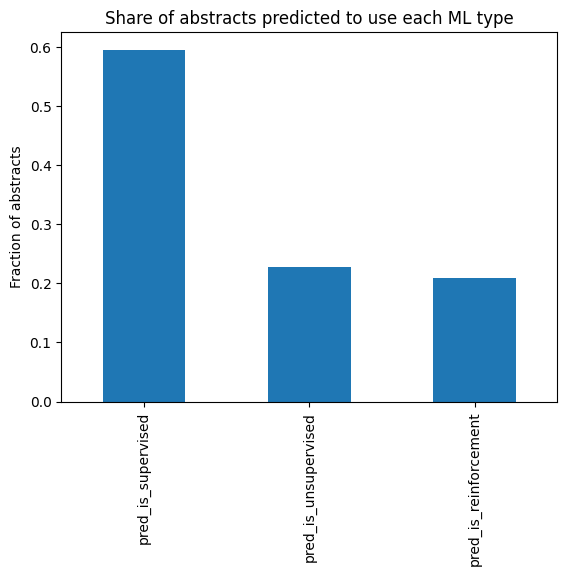

In [13]:
df[pred_cols].mean().plot(kind="bar")
plt.title("Share of abstracts predicted to use each ML type")
plt.ylabel("Fraction of abstracts")
plt.show()

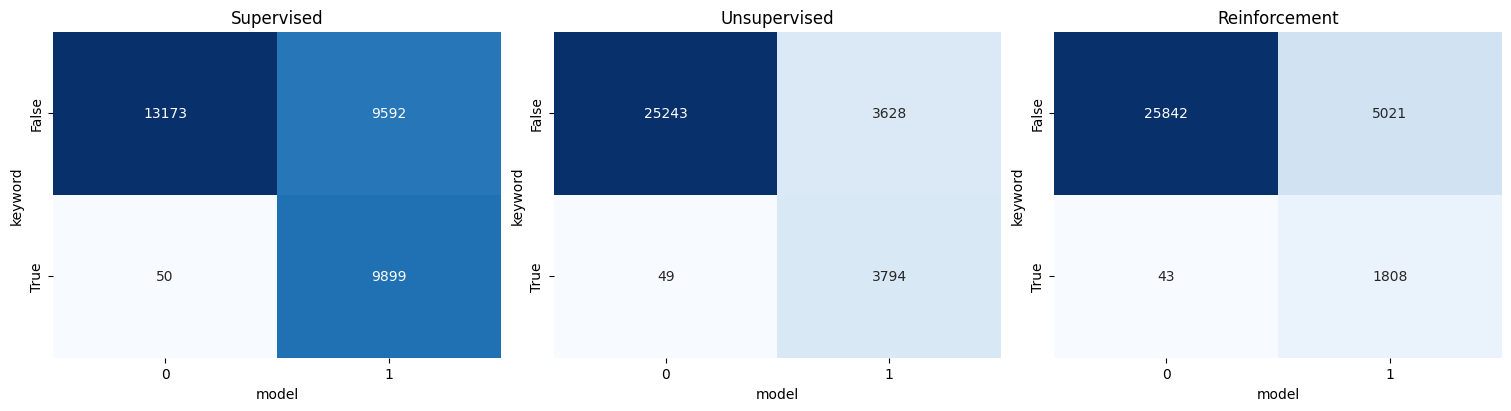

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"pred_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [15]:
# Small per-label stats
for col in label_cols:
    pred = df[f"pred_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 9899
FP: 9592
FN: 50
TN: 13173
Precision: 0.508
Recall:    0.995


=== is_unsupervised ===
TP: 3794
FP: 3628
FN: 49
TN: 25243
Precision: 0.511
Recall:    0.987


=== is_reinforcement ===
TP: 1808
FP: 5021
FN: 43
TN: 25842
Precision: 0.265
Recall:    0.977



In [16]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"pred_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"pred_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
26115,10.15530/urtec-2022-3720957,An Accurate and Efficient Fracture Propagation...,copyright unconventional resources technology ...,True,True,False,1,0,0
21227,10.48308/esrj.2025.232122.1181,Determination of petrophysical rock types and ...,by the authorsintroduction the study and evalu...,True,True,False,0,1,0
21137,10.1016/j.uncres.2025.100238,A proxy-assisted multi-layer cooperative optim...,the authorsshale gas development optimization ...,True,True,False,0,1,0
21002,10.1038/s41598-025-93225-9,Adaptive hybrid segmentation combined with met...,plant diseases can damage specific parts of le...,True,True,False,0,1,0
11225,10.1109/ICNGN63705.2024.10871832,Application of Machine Learning Algorithms in ...,ieeedigital twins represent virtual replicas o...,False,True,False,0,1,1
21053,10.1007/s42107-025-01440-6,Integrated data-driven optimization and micros...,under exclusive licence to springer nature swi...,True,True,False,1,0,0
18865,NaN,15th International Conference on Management of...,the proceedings contain papers the special foc...,True,True,False,0,1,1
19102,NaN,A Novel Approach for Customer Segmentation and...,bharati vidyapeeth new delhipersonalized marke...,False,True,False,1,1,0
17200,10.1016/j.porgcoat.2025.109265,High-throughput and explainable machine learni...,the authorshighthroughput equipment was employ...,False,False,True,1,0,0
25105,10.1108/IJICC-12-2021-0300,GSA-based support vector neural network: a mac...,emerald publishing limitedpurpose automated cr...,True,True,True,1,0,1


In [17]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"pred_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("=== Predictions on TRAINED rows ===")
print(pred_counts_train)
print("\n=== Predictions on NON-TRAINED rows ===")
print(pred_counts_not_train)


=== Predictions on TRAINED rows ===
pred_is_supervised       9929
pred_is_unsupervised     3817
pred_is_reinforcement    1819
dtype: int64

=== Predictions on NON-TRAINED rows ===
pred_is_supervised       9562
pred_is_unsupervised     3605
pred_is_reinforcement    5010
dtype: int64
